# Time Series Analysis Example

Working through code from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
and https://www.machinelearningplus.com/time-series/time-series-analysis-python/ with added sections where details were lacking

## Data Exploration

In [1]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Import as Dataframe
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
#df.head()

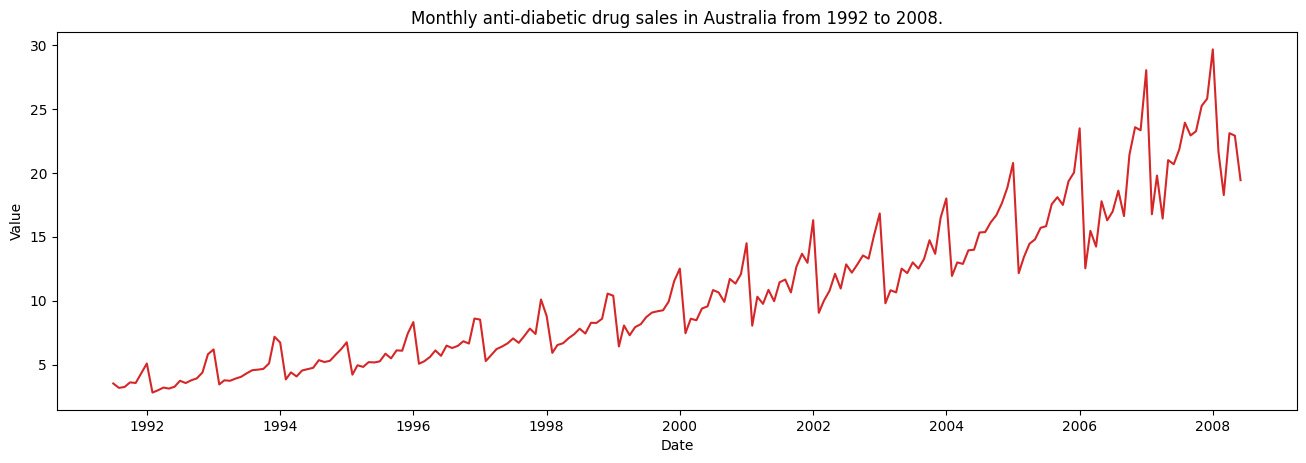

In [2]:
# Time series data source: fpp pacakge in R.
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

A yearly spike in the sales can be seen every year, thus we plot each year to see the seasonality of the data

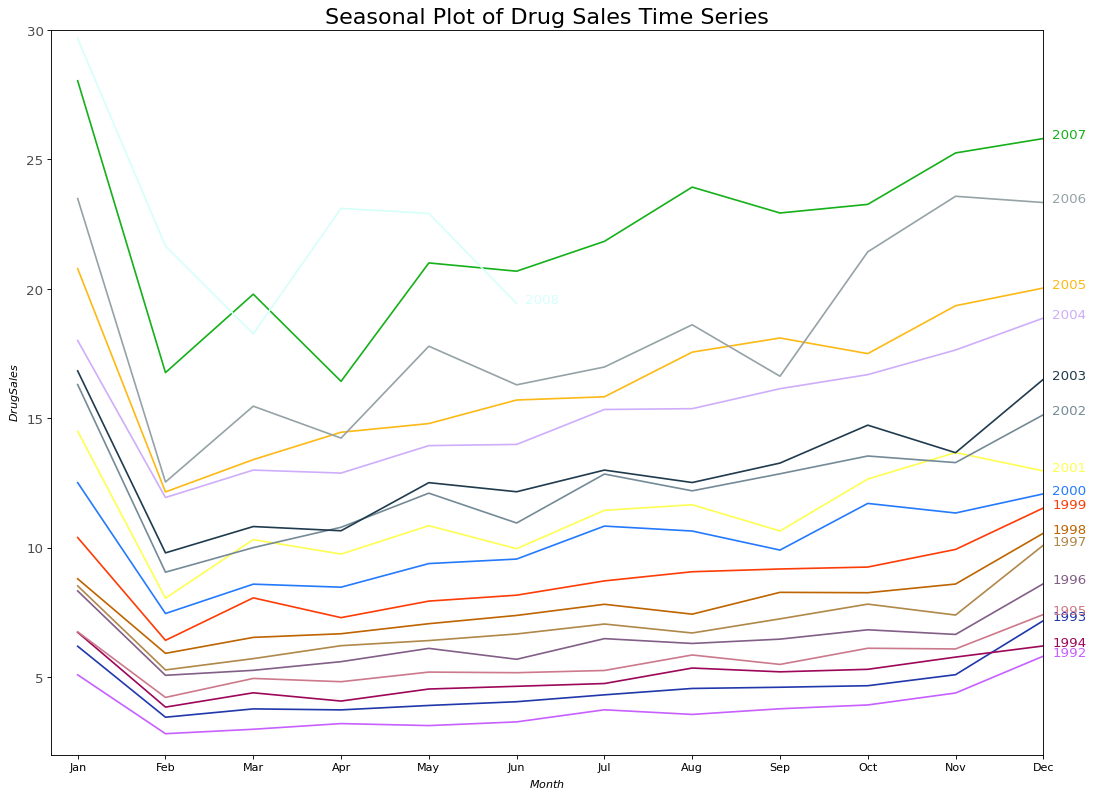

In [3]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'value', data=df.loc[df.year==y, :], color=mycolors[i], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='$Drug Sales$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Drug Sales Time Series", fontsize=20)
plt.show()

Two characteristics of the data that are clear from this graph are:
* The total number of sales genereally each consecutive year.
* There is a server drop in sales for the month of Feburary and an increase in March every year 

Now we will plot two boxplots to better illustrate this
* Yearly (trend)
* Monthly (seasonality)

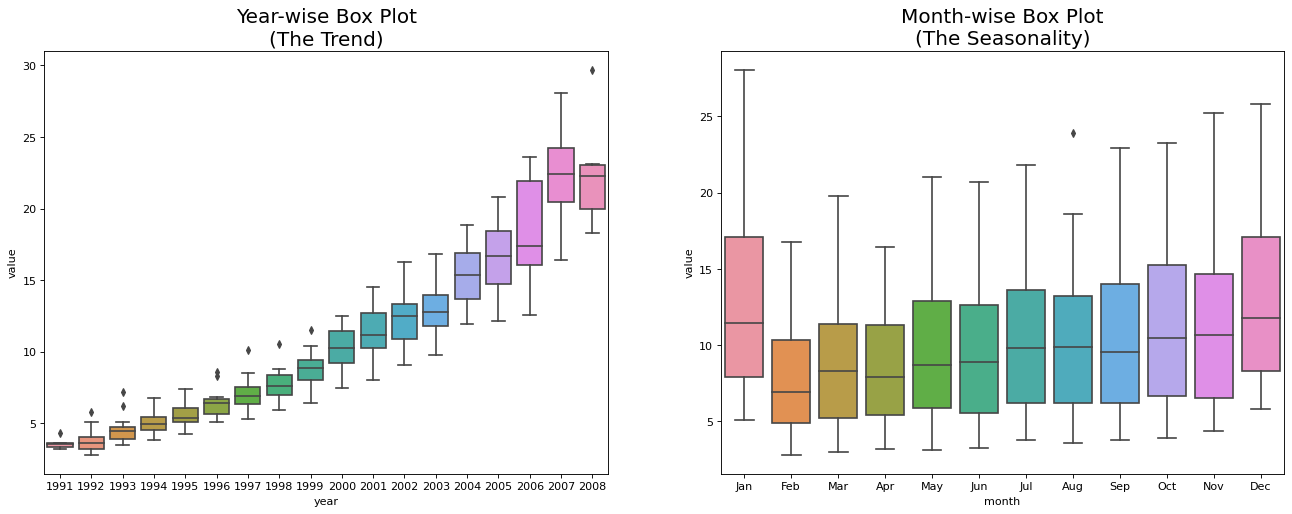

In [4]:
# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.strftime('%b') for d in df.date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

A time series can be represented as:

Current Value = Baseline ( constant ) + Trend ( y = g(x) ) + Seasonality/Cyclical ( y = g( x(n) ) ~ g( x(n+T) ) ) + Error( true_y - esti_y )

Seasonality is connected to date based trends, whereas cyclical data is dependant on some other cycle.

<AxesSubplot:title={'center':'Trend and Seasonality'}, xlabel='date'>

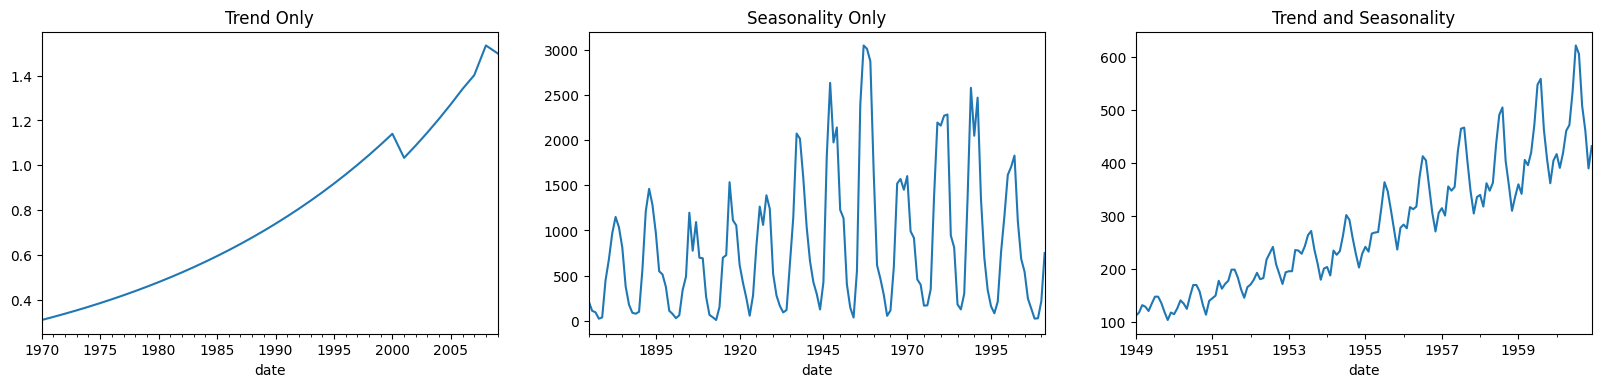

In [5]:
fig, axes = plt.subplots(1,3, figsize=(20,4), dpi=100)
pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/guinearice.csv', parse_dates=['date'], index_col='date').plot(title='Trend Only', legend=False, ax=axes[0])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv', parse_dates=['date'], index_col='date').plot(title='Seasonality Only', legend=False, ax=axes[1])

pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv', parse_dates=['date'], index_col='date').plot(title='Trend and Seasonality', legend=False, ax=axes[2])

A series can either be additive or multiplicative in its components

* Additive series = baseline + trend + seasonality + error
* Multiplicative series = baseline * trend * seasonality * error

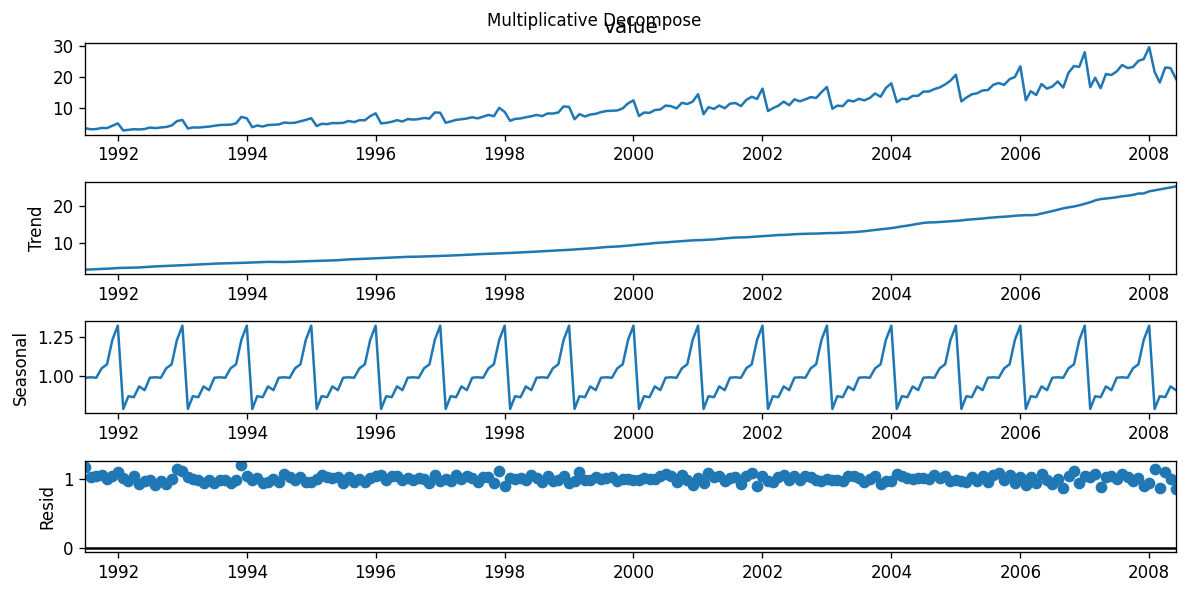

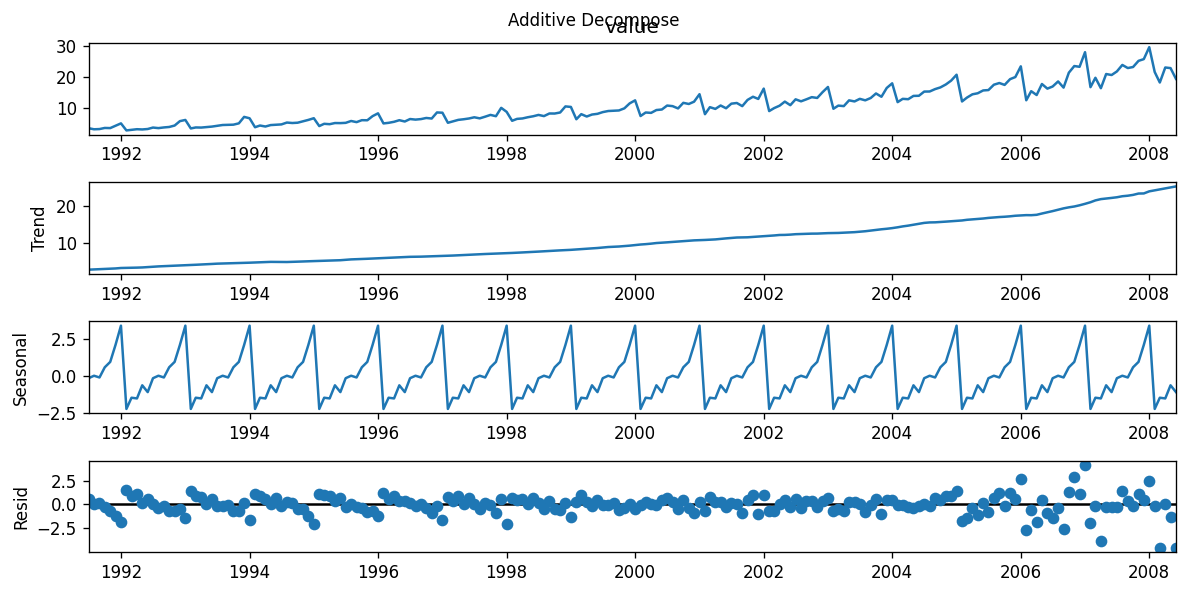

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
result_add.plot().suptitle('Additive Decompose', fontsize=10)
plt.show()

Setting extrapolate_trend='freq' takes care of any missing values in the trend and residuals at the beginning of the series.

Comparing the residuals:

* Multiplicative: Appears to be white noise(random), which is desired for the error
* Additive: Some of the pattern remains

## Stationarity

A stochastic process **x**(t) is Strict Sense Stationary(SSS) if its statistical properties are invariant to shifts of the origin.
* f(x;t) = f(x;t+c) = f(x) for all c
* f(x_1,x_2;t_1,t_2) = f(x_1,x_2;T) for c=-t2, and T=t_1-t_2

A stochastic process **x**(t) is Wide Sense Stationary(WSS) if 
* E{**x**(t)} = nu (mean is constant)
* R(T), T=t_1-t_2 (Autocorrelation is dependant on time difference and not a particular t)

Note: For WSS process average power = R(0) and is independant of t 


A stationary time series is desired as a AutoRegressive(AR) filter is linear regression with the lagged series used as the predictor. Linear regression performs best when the correlation between variables is small (ideal for independant predictors), which is provided by a stationary time series.

### Methods to make time series more stationary

* Difference the series (Y_x = Y_t - Y_(t-1))
* Log series (Y_x = log(Y_t))
* Take nth root of the series
* Any combination of the above

### Test for Stationarity

This is done by the unit root test with common complimentary ones being:
* Augmented Dickey Fuller (ADF) Test
* Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In the more commonly used ADF test the null hypothesis is: The series possess a unit root and is nonstationary. So for a p value (likelihood of the hyphothesis occuring) less than significance level we reject the null hypthosis. The KPSS tests for stationarity in the prescence of a trend, thus the null hypothesis is the series is trend stationary.

<span style="color: red;">
Return and add statistics
</span>

In [8]:
from statsmodels.tsa.stattools import adfuller, kpss
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.1451856893067363
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476

KPSS Statistic: 2.013126
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


c:\users\julba\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


For a significance level of 0.05, ADF has a p value of 1 thus we accept the null hyphothesis that the series is non-stationary. The KPSS p value is 0.01 thus we reject the hyphothesis that the series is trend stationary. From this we conclude the series is nonstationary.

* If KPSS indicates stationarity and ADF doesn't then the series is trend stationary and must be detrended
* If ADF indicates stationarity and KPSS doesn't then the series is difference stationary and must be differenced.

<span style="color: red;">
Return and do test on difference series
</span>

### Detrend a time series

Methods
* Subtract the line of best fit usually obtained using linear regression (can use quadratic of higher order regression)
* Subtract trend component, obtained from STL decomposition
* Subtract mean
* Filter out moving average trend lines and cyclical componets using Baxter-King filter or Hodrick-Prescott filter

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the least squares fit')

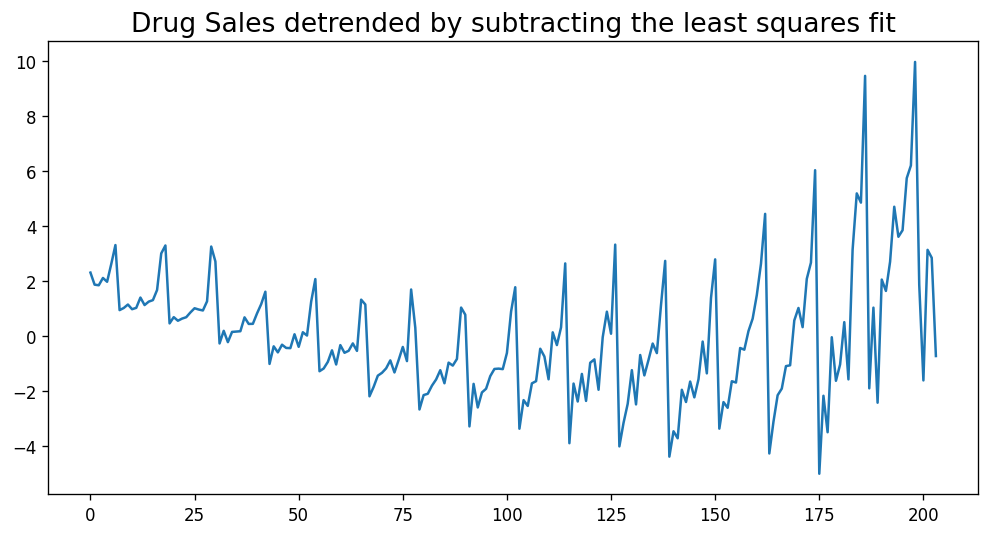

In [9]:
# Using scipy: Subtract the line of best fit
from scipy import signal
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
detrended = signal.detrend(df.value.values)
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'Drug Sales detrended by subtracting the trend component')

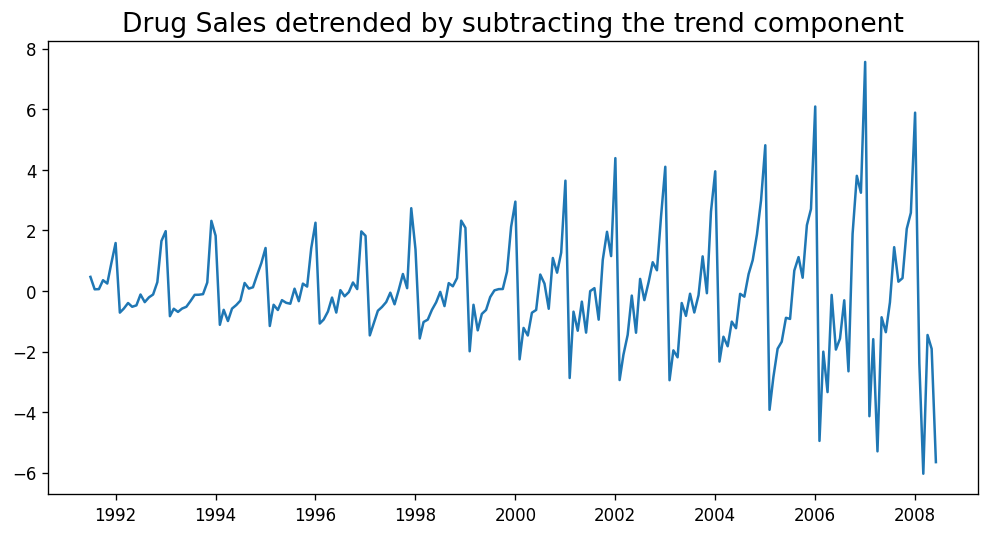

In [10]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = df.value.values - result_mul.trend
plt.plot(detrended)
plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)

## Seasonality

This can be seen by using autocorrelation such as in the below graph, with spikes every multiple of 12 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

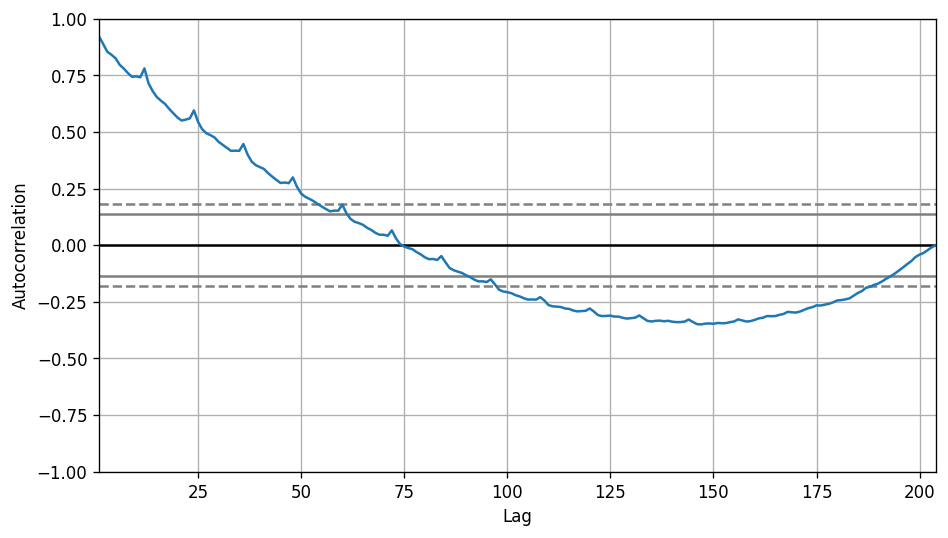

In [11]:
from pandas.plotting import autocorrelation_plot
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

A test statistic to explore is Canova-Hansen(CH) test

### AutoCorrelation Function (ACF) Vs Partial AutoCorrelation Function (PACF)

Variance(X) = E((X-x)^2)  where x is mean of X
Sample Variance 1/(N-1) + Sum((X-x)^2)
Covariance(X,Y)=E(X-x)E(Y-y) where x,y are respective means

k is the lag

ACF(X) = Covariance(X_t,X_(t+k)) / ( sqrt(Var(X_t))* sqrt(Var(X_(t+k)))     
                                            

PACF(X,k) = Covariance(X_t,X_(t+k) | X_(t+1), X(t+2), ..., X_(t+k-1)) / 
( sqrt(Var(X_t | X_(t+1), X(t+2), ..., X_(t+k-1)))* sqrt(Var(X_(t+k) | X_(t+1), X(t+2), ..., X_(t+k-1))) 

Thus PACF excludes the effect of previous entries in autocorrelation of the kth entry by using a conditional density.

c:\users\julba\appdata\local\programs\python\python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


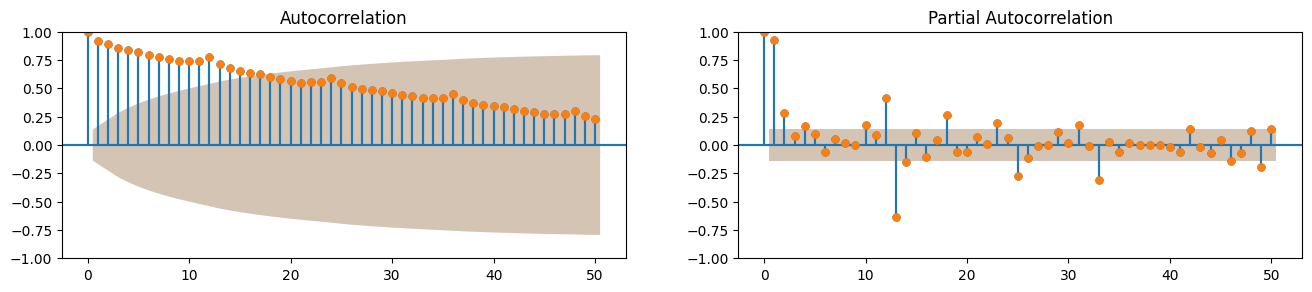

In [13]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
#fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

The PACF provides a useful measure to determine the order of an AR filter, in this case AR(2) is a good choice.

Another way to visually see the autocorrelation is with the lag plots below. The closer grouped the plots the higher the correlation. AS the lag progresses the plots become more random and thus less correlated. 

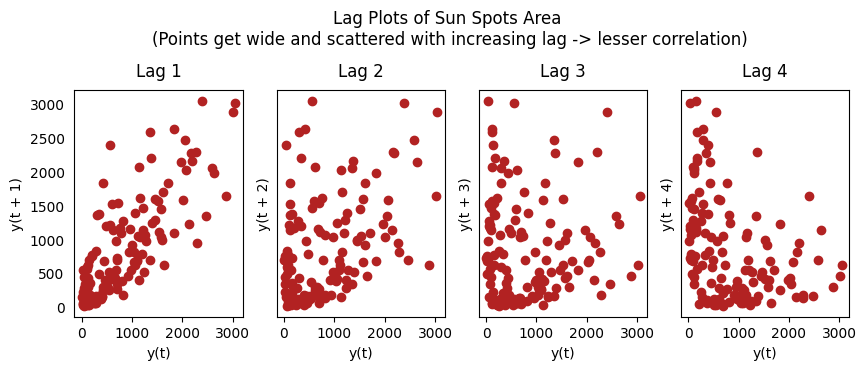

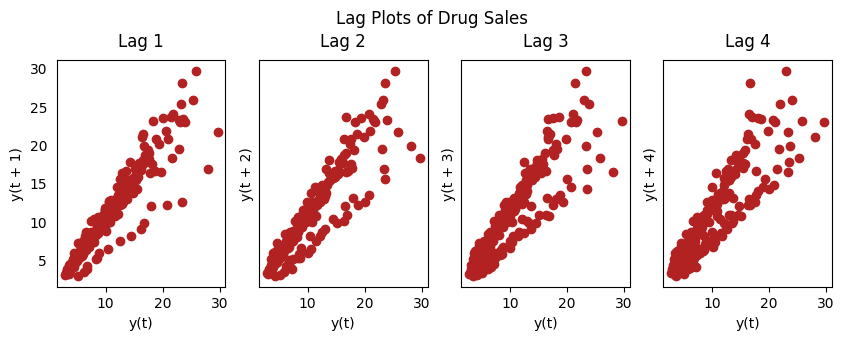

In [14]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

### Deseasonalise Time Series

* Use MA filter of size equal to the season window. Will smooth the output as it is a lowpass filter.
* Subtract previous season value from current value (Seasonal difference)
* Divide the series by seasonal index, obtained from STL decomposition

Note: If dividing by seasonal index doesn't work take log of series as it will reduce multiplication to addition

[]

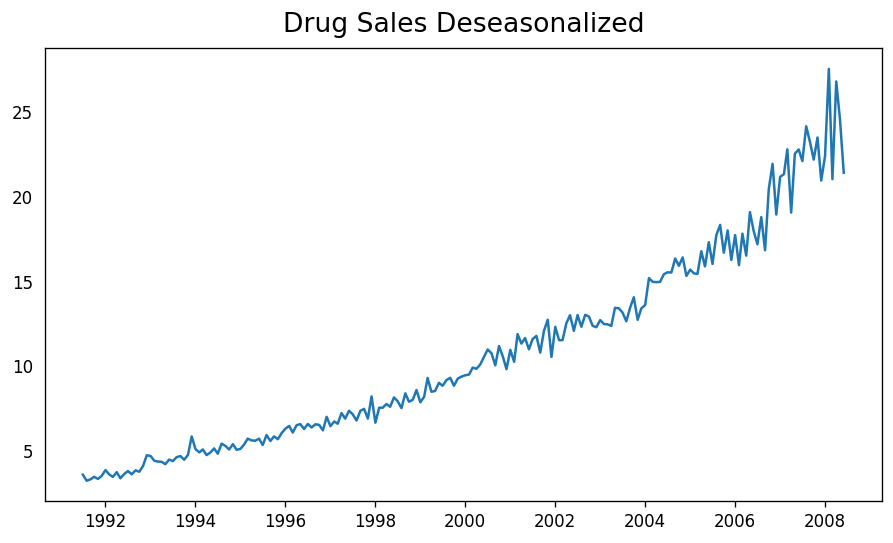

In [16]:
# Subtracting the Trend Component.
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Time Series Decomposition
result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = df.value.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Drug Sales Deseasonalized', fontsize=16)
plt.plot()

## Dealing with missing values

Filling the missing values with the mean is not advisable, instead use:

* Forward/Backwards fill (use last value as fill value)
* Interpolation between measured points (linear/cubic)
* The mean of k-Nearest Neignbours (kNN) 
* The mean of seasonal counterparts

For kNN with k = 8 and index = 31 then average the values located at {27,28,29,30,32,33,34,35} 
For seasonal all previous values are averaged eg index = 67 and seasonality = 12, so we average values located at
{66,54,42,30,18,6}

In [75]:
a = np.array([1,2,3,4,5,6,7,8])
print(a[5::-2] )
print("a[5]=6 the :: tells numpy to move index by integer value, in this case -2. So the next value is a[5-2]=a[3]=4")
print("Next a[3-2]=a[1]=2. Lastly a[1-2]=a[-1] which is out of bounds thus we stop")
print(a[5-1::-2])

[6 4 2]
a[5]=6 the :: tells numpy to move index by integer value, in this case -2. So the next value is a[5-2]=a[3]=4
Next a[3-2]=a[1]=2. Lastly a[1-2]=a[-1] which is out of bounds thus we stop
[5 3 1]


<ipython-input-62-3965217efd1e>:75: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(ts_seas)):


<AxesSubplot:title={'center':'Seasonal Mean (MSE: 0.78)'}, xlabel='date'>

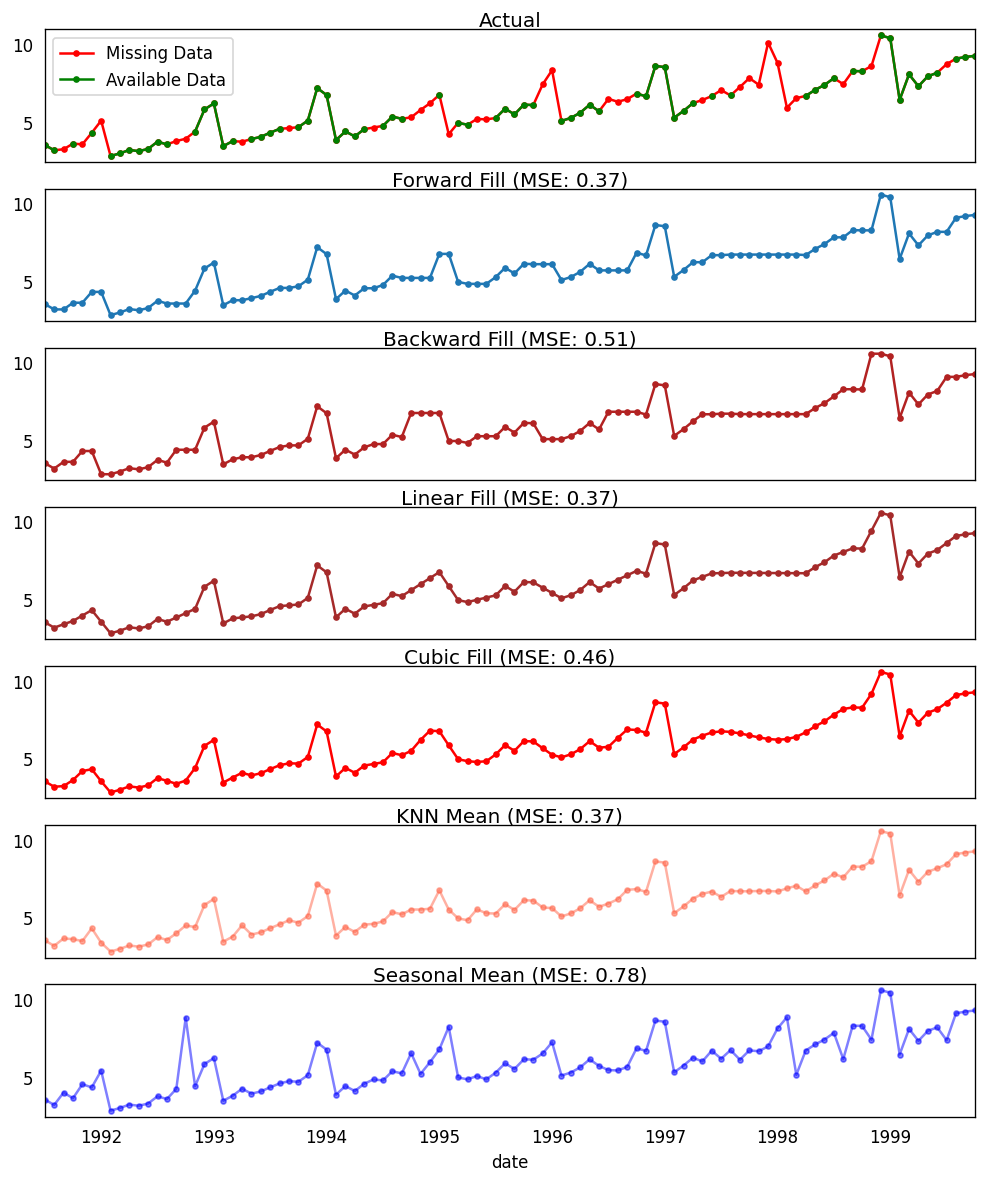

In [62]:
# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
df_orig = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date').head(100)
#df = pd.read_csv('datasets/a10_missings.csv', parse_dates=['date'], index_col='date')
df = df_orig.copy(deep=True)
list_missing = {3,5,7,15,16,22,27,36,40,41,42,44,47,48,54,55,61,62,63,71,73,75,76,77,78,79,80,81,86,89,97}
for indx in list_missing:
    df.iloc[indx-1]['value'] = np.nan

fig, axes = plt.subplots(7, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})
plt.rcParams['axes.titley'] = .9#.7

## 1. Actual -------------------------------
df_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

## 2. Forward Fill --------------------------
df_ffill = df.ffill()
error = np.round(mean_squared_error(df_orig['value'], df_ffill['value']), 2)
df_ffill['value'].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df.bfill()
error = np.round(mean_squared_error(df_orig['value'], df_bfill['value']), 2)
df_bfill['value'].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

## 4. Linear Interpolation ------------------
df['rownum'] = np.arange(df.shape[0])
df_nona = df.dropna(subset = ['value'])
f = interp1d(df_nona['rownum'], df_nona['value'])
df['linear_fill'] = f(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['linear_fill']), 2)
df['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], label='Cubic Fill', color='brown', style=".-")

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
df['cubic_fill'] = f2(df['rownum'])
error = np.round(mean_squared_error(df_orig['value'], df['cubic_fill']), 2)
df['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], label='Cubic Fill', color='red', style=".-")

# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df['knn_mean'] = knn_mean(df.value.values, 8)
error = np.round(mean_squared_error(df_orig['value'], df['knn_mean']), 2)
df['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], label='KNN Mean', color='tomato', alpha=0.5, style=".-")

## 7. Seasonal Mean ----------------------------
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

df['seasonal_mean'] = seasonal_mean(df.value, n=12, lr=1.25)
error = np.round(mean_squared_error(df_orig['value'], df['seasonal_mean']), 2)
df['seasonal_mean'].plot(title="Seasonal Mean (MSE: " + str(error) +")", ax=axes[6], label='Seasonal Mean', color='blue', alpha=0.5, style=".-")

More precise alternatives include:

* If explanatory variables (External to time series) are present use a prediction model like random forest or kNN to predict it.
* If enough samples are present forecast it (back forecast if value occur after)

## Forecastability

Two statistics used to measure the predictability of a time series are:
* Approximate entropy
* Sample entropy

### Approximate entropy

For a series of length N, a window length m < N is selected as well as a real number r >= 0 which dependant on the application. 

Next


In [76]:
# https://en.wikipedia.org/wiki/Approximate_entropy
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.16083502693096996
0.5972926771842966
